# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [1]:
t

In [2]:
!pip install dlomix

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40722 sha256=a5156f74e8400269387b33968cad5bd36f235e342dc6e040e32b07d022f7bdc8
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [3]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


0

In [5]:
wandb.init(project='precursor_charge_prediction_new')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


# Create DLMOX model class

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense
from tensorflow.keras.models import Model

# Sample data (replace this with your own dataset)
# Here, the first column contains single integers, and the remaining columns contain 3-tuples.
# Each row is represented as a list [int, (int, int, int), (int, int, int), ...]
data = [
    [1, (10, 20, 30), (40, 50, 60)],
    [2, (11, 22, 33), (44, 55, 66)],
    [3, (12, 24, 36), (48, 60, 72)],
    # Add more data rows here
]

# Convert the data to numpy arrays
data = np.array(data)

# Extract the first column (single integer column)
integer_data = data[:, 0]

# Extract the rest of the columns (3-tuple columns)
tuple_data = data[:, 1:]

# Define the number of unique integer values in the first column (adjust this based on your dataset)
num_unique_integers = 10  # Just an example, you should set this based on your data

# Define the number of features in the 3-tuple columns (always 3 in this case)
num_features_in_tuple = 3

# Model inputs
integer_input = Input(shape=(1,), name='integer_input')
tuple_input = Input(shape=(tuple_data.shape[1], num_features_in_tuple), name='tuple_input')

# Embedding layer for the integer input
embedded_integer = Embedding(input_dim=num_unique_integers, output_dim=10, input_length=1)(integer_input)

# Flatten the embedded_integer layer to match the shape of the tuple_input
flattened_integer = tf.keras.layers.Flatten()(embedded_integer)

# Concatenate the flattened_integer and tuple_input
concatenated = Concatenate(axis=-1)([flattened_integer, tuple_input])

# Add additional layers as needed
# Example: dense_layer = Dense(64, activation='relu')(concatenated)

# Model output
# Example: output = Dense(num_classes, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[integer_input, tuple_input], outputs=output)

# Compile the model (add loss, optimizer, metrics as appropriate for your task)
# Example: model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


/tmp/ipykernel_28/2833128987.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 10), (None, 2, 3)]

 1.23 A B C D E
 1.23 E D C A B
 o o o o o o

 1.23, ABC, BCD, CDE, ABCD, BCDE

In [7]:
#%pip install dlomix
from dlomix.constants import ALPHABET_UNMOD
from dlomix.layers.attention import AttentionLayer, DecoderAttentionLayer
class PrositChargeStatePredictor(tf.keras.Model):

    def __init__(
        self,
        embedding_output_dim=16,
        seq_length=50,
        vocab_dict=ALPHABET_UNMOD,
        dropout_rate=0.5,
        latent_dropout_rate=0.1,
        recurrent_layers_sizes=(256, 512),
        regressor_layer_size=512,
    ):
        super(PrositChargeStatePredictor, self).__init__()

        # tie the count of embeddings to the size of the vocabulary (count of amino acids)
        self.embeddings_count = len(vocab_dict) + 2

        self.dropout_rate = dropout_rate
        self.latent_dropout_rate = latent_dropout_rate
        self.regressor_layer_size = regressor_layer_size
        self.recurrent_layers_sizes = recurrent_layers_sizes

        self.string_lookup = preprocessing.StringLookup(
            vocabulary=list(vocab_dict.keys())
        )

        self.embedding = tf.keras.layers.Embedding(
            input_dim=self.embeddings_count,
            output_dim=embedding_output_dim,
            input_length=seq_length,
        )
        self._build_encoder()

        self.attention = AttentionLayer()

        self.regressor = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(self.regressor_layer_size, activation="relu"),
                tf.keras.layers.Dropout(rate=self.latent_dropout_rate),
            ]
        )

        self.output_layer = tf.keras.layers.Dense(6, activation="softmax") # TODO num_classes

    def _build_encoder(self):
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Bidirectional(
                    tf.keras.layers.GRU(
                        units=self.recurrent_layers_sizes[0], return_sequences=True
                    )
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.GRU(
                    units=self.recurrent_layers_sizes[1], return_sequences=True
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
            ]
        )

    def call(self, inputs, **kwargs):
        x = self.string_lookup(inputs)
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.attention(x)
        x = self.regressor(x)
        x = self.output_layer(x)
        return x

# Create DLomix dataset format

In [8]:
def get_most_abundant(df_charge_list, df_intensity_list, debug=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if debug:
        print(charge_dict)
    return max(charge_dict, key=charge_dict.get)

In [9]:
def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    if isinstance(int_value, np.integer):
        one_hot = [1 if x == int_value else 0 for x in charges]
    else:
        one_hot = int_value

    return one_hot

In [38]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from dlomix.constants import DEFAULT_PARQUET_ENGINE

"""
 TODO: check if it is better to abstract out a generic class for TF dataset wrapper, including:
 - splitting data logic (e.g. include task-specific stratification based on sequence length, iRT values)
 - loading data logic
 """

# take into consideration if the pandas dataframe is pickled or not and then call read_pickle instead of read_csv
# allow the possiblity to have three different dataset objects, one for train, val, and test


class ChargeStateDataset:
    r"""A dataset class for Retention Time prediction tasks. It initialize a dataset object wrapping tf.Dataset and some relevant preprocessing steps.

    Parameters
    -----------
    data_source : str, tuple of two numpy.ndarray, numpy.ndarray, optional
        source can be a tuple of two arrays (sequences, targets), single array (sequences), useful for test data, or a str with a file path to a csv file. Defaults to None.
    sep : str, optional
        separator to be used if the data source is a CSV file. Defaults to ",".
    sequence_col :  str, optional
        name of the column containing the sequences in the provided CSV. Defaults to "sequence".
    target_col : str, optional
        name of the column containing the targets (indexed retention time). Defaults to "irt".
    feature_cols : list, optional
        a list of columns containing other features that can be used later as inputs to a model. Defaults to None.
    normalize_targets : bool, optional
        a boolean whether to normalize the targets or not (subtract mean and divied by standard deviation). Defaults to False.
    seq_length : int, optional
        the sequence length to be used, where all sequences will be padded to this length, longer sequences will be removed and not truncated. Defaults to 0.
    batch_size : int, optional
        the batch size to be used for consuming the dataset in training a model. Defaults to 32.
    val_ratio : int, optional
        a fraction to determine the size of the validation data (0.2 = 20%). Defaults to 0.
    seed: int, optional
        a seed to use for splitting the data to allow for a reproducible split. Defaults to 21.
    test :bool, optional
        a boolean whether the dataset is a test dataset or not. Defaults to False.
    path_aminoacid_atomcounts : str, optional
        a string with a path to a CSV table with the atom counts of the different amino acids (can be used for feature extraction). Defaults to None.
    sample_run : bool, optional
        a boolean to limit the number of examples to a small number, SAMPLE_RUN_N, for testing and debugging purposes. Defaults to False.
    """
    ATOM_TABLE = None
    SPLIT_NAMES = ["train", "val", "test"]
    BATCHES_TO_PREFETCH = tf.data.AUTOTUNE

    SAMPLE_RUN_N = 100
    METADATA_KEY = "metadata"
    PARAMS_KEY = "parameters"
    TARGET_NAME_KEY = "target_column_key"

    # TODO: For test dataset --> examples with longer sequences --> do not drop, add NaN for prediction

    def __init__(
        self,
        data_source=None,
        sep=",",
        intensity_col="precursor_intensity",
        sequence_col="modified_sequence", # TODO !!!
        target_col="precursor_charge",
        feature_cols=None,
        normalize_targets=False,
        seq_length=0,
        batch_size=32,
        val_ratio=0,
        seed=21,
        test=False,
        path_aminoacid_atomcounts=None,
        sample_run=False,
    ):
        super(ChargeStateDataset, self).__init__()

        np.random.seed(seed)
        self.seed = seed

        self.data_source = data_source
        self.sep = sep
        self.intensity_col = intensity_col
        self.sequence_col = sequence_col.lower()
        self.target_col = target_col.lower()
        if feature_cols:
            self.feature_cols = [f.lower() for f in feature_cols]
        else:
            self.feature_cols = []

        self.normalize_targets = normalize_targets
        self.sample_run = sample_run

        # if seq_length is 0 (default) -> no padding
        self.seq_length = seq_length

        self._data_mean = 0
        self._data_std = 1

        self.batch_size = batch_size
        self.val_ratio = val_ratio
        self.testing_mode = test

        self.main_split = (
            ChargeStateDataset.SPLIT_NAMES[2]
            if self.testing_mode
            else ChargeStateDataset.SPLIT_NAMES[0]
        )

        self.sequences = None
        self.targets = None
        self.features_df = None
        self.example_id = None

        # if path to counts lookup table is provided, include count features, otherwise not
        self.include_count_features = True if path_aminoacid_atomcounts else False

        if self.include_count_features:
            self.aminoacid_atom_counts_csv_path = (
                path_aminoacid_atomcounts  # "../lookups/aa_comp_rel.csv"
            )
            self._init_atom_table()

        # initialize TF Datasets dict
        self.tf_dataset = (
            {self.main_split: None, ChargeStateDataset.SPLIT_NAMES[1]: None}
            if val_ratio != 0
            else {self.main_split: None}
        )

        self.indicies_dict = (
            {self.main_split: None, ChargeStateDataset.SPLIT_NAMES[1]: None}
            if val_ratio != 0
            else {self.main_split: None}
        )

        # if data is provided with the constructor call --> load, otherwise --> done
        if self.data_source is not None:
            self.load_data(data=data_source)

    def _init_atom_table(self):
        atom_counts = pd.read_csv(self.aminoacid_atom_counts_csv_path)
        atom_counts = atom_counts.astype(str)

        keys_tensor = tf.constant(atom_counts["aa"].values)
        values_tensor = tf.constant(
            ["_".join(c) for c in list(atom_counts.iloc[:, 1:].values)]
        )
        init = tf.lookup.KeyValueTensorInitializer(keys_tensor, values_tensor)
        ChargeStateDataset.ATOM_TABLE = tf.lookup.StaticHashTable(
            init, default_value="0_0_0_0_0"
        )

    def load_data(self, data):
        """Load data into the dataset object, can be used to load data at a later point after initialization.
        This function triggers the whole pipeline of: data loading, validation (against sequence length), splitting, building TensorFlow dataset objects, and apply preprocessing.

        :param data: can be: tuple of two arrays (sequences, targets), single array (sequences), useful for test data, or a `str` with a file path toa csv file
        :return: None
        """
        self.data_source = data

        self._read_data()
        self._validate_remove_long_sequences()
        self._split_data()
        self._build_tf_dataset()
        self._preprocess_tf_dataset()
        #self.targets = [one_hot_precursor(x) for x in self.targets]


    """
    numpy array --> either a tuple or a single array
        - Tuple --> means (sequences, targets)
        - single ndarray --> means sequences only, useful for test dataset
    str --> path to csv file or compressed csv file
    """

    def _read_data(self):
        if isinstance(self.data_source, dict):
            self._update_data_loading_for_json_format()

        if isinstance(self.data_source, tuple):
            tuple_size_is_two = len(self.data_source) == 2
            if tuple_size_is_two:
                tuple_elements_are_ndarray = isinstance(
                    self.data_source[0], np.ndarray
                ) and isinstance(self.data_source[1], np.ndarray)
                if tuple_elements_are_ndarray:
                    self.sequences = self.data_source[0]
                    self.targets = self.data_source[1]
            else:
                raise ValueError(
                    "If a tuple is provided, it has to have a length of 2 and both elements should be numpy arrays."
                )

        elif isinstance(self.data_source, np.ndarray):
            self.sequences = self.data_source
            self.targets = np.zeros(self.sequences.shape[0])
            self._data_mean, self._data_std = 0, 1

        elif isinstance(self.data_source, (str, dict)):
            if isinstance(self.data_source, dict):
                #  a dict is passed via the json
                df = pd.DataFrame(self.data_source)
            else:
                # a string path is passed via the json or as a constructor argument
                df = self._resolve_string_data_path()

            # used only for testing with a smaller sample from a csv file
            if self.sample_run:
                df = df.head(ChargeStateDataset.SAMPLE_RUN_N)

            # lower all column names
            df.columns = [col_name.lower() for col_name in df.columns]

            self.sequences, self.targets, self.intensities = (
                df[self.sequence_col].values,
                df[self.target_col].values,
                df[self.intensity_col].values,
            )
            
            self.targets = np.array([one_hot_precursor(x) for x in self.targets]) # here
            
            self._data_mean, self._data_std = np.mean(self.targets), np.std(
                self.targets
            )

            self.features_df = df[self.feature_cols]
        else:
            raise ValueError(
                "Data source has to be either a tuple of two numpy arrays, a single numpy array, "
                "or a string with a path to a csv/parquet/json file."
            )

        # give the index of the element as an ID for later reference if needed
        self.example_id = list(range(len(self.sequences)))

    def _update_data_loading_for_json_format(self):
        json_dict = self.data_source

        self.data_source = json_dict.get(ChargeStateDataset.METADATA_KEY, "")
        self.target_col = json_dict.get(ChargeStateDataset.PARAMS_KEY, {}).get(
            ChargeStateDataset.TARGET_NAME_KEY, self.target_col
        )
        # ToDo: make dynamic based on parameters
        self.sequence_col = "modified_sequence"
        self.intensity_col = "precursor_intensity"

    def _resolve_string_data_path(self):
        is_json_file = self.data_source.endswith(".json")

        if is_json_file:
            json_dict = read_json_file(self.data_source)
            self._update_data_loading_for_json_format(json_dict)

        is_parquet_url = ".parquet" in self.data_source and self.data_source.startswith(
            "http"
        )
        is_parquet_file = self.data_source.endswith(".parquet")
        is_csv_file = self.data_source.endswith(".csv")

        if is_parquet_url or is_parquet_file:
            df = read_parquet_file_pandas(self.data_source, DEFAULT_PARQUET_ENGINE)

            # TODO build it into the class
            df = df.groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
            for index, row in df.iterrows():
                df.at[index, "precursor_charge"] = get_most_abundant(row["precursor_charge"], row["precursor_intensity"])
            df["precursor_charge"] = df["precursor_charge"].astype(int)


            return df
        elif is_csv_file:
            df = pd.read_csv(self.data_source)
            return df
        else:
            raise ValueError(
                "Invalid data source provided as a string, please provide a path to a csv, parquet, or "
                "or a json file."
            )

    def _validate_remove_long_sequences(self) -> None:
        """
        Validate if all sequences are shorter than the padding length, otherwise drop them.
        """
        assert self.sequences.shape[0] > 0, "No sequences in the provided data."
        assert len(self.sequences) == len(
            self.targets
        ), "Count of examples does not match for sequences and targets."

        limit = self.seq_length
        vectorized_len = np.vectorize(lambda x: len(x))
        mask = vectorized_len(self.sequences) <= limit
        self.sequences, self.targets = self.sequences[mask], self.targets[mask]
        # once feature columns are introduced, apply the mask to the feature columns (subset the dataframe as well)

    def _split_data(self):
        n = len(self.sequences)

        if self.val_ratio != 0 and (not self.testing_mode):
            # add randomization for now and later consider the splitting logic
            self.indicies_dict[ChargeStateDataset.SPLIT_NAMES[1]] = np.arange(n)[
                : int(n * self.val_ratio)
            ]
            self.indicies_dict[self.main_split] = np.arange(n)[
                int(n * self.val_ratio) :
            ]
        else:
            self.indicies_dict[self.main_split] = np.arange(n)

    def _build_tf_dataset(self):
        # consider adding the feature columns or extra inputs
        for split in self.tf_dataset.keys():
            self.tf_dataset[split] = tf.data.Dataset.from_tensor_slices(
                (
                    self.sequences[self.indicies_dict[split]],
                    self.targets[self.indicies_dict[split]],
                )
            )

    def _preprocess_tf_dataset(self):
                
        for split in self.tf_dataset.keys():
            # avoid normalizing targets for test data --> should not be needed
            if self.normalize_targets and not self.testing_mode:
                self.tf_dataset[split] = self.tf_dataset[split].map(
                    lambda s, t: self._normalize_target(s, t),
                    num_parallel_calls=tf.data.AUTOTUNE,
                )

            self.tf_dataset[split] = (
                self.tf_dataset[split]
                .map(
                    lambda s, t: self._split_sequence(s, t),
                    num_parallel_calls=tf.data.AUTOTUNE,
                )
                .map(
                    lambda s, t: self._pad_sequences(s, t),
                    num_parallel_calls=tf.data.AUTOTUNE,
                )
            )
            if self.include_count_features:
                self.tf_dataset[split] = (
                    self.tf_dataset[split]
                    .map(
                        ChargeStateDataset._convert_inputs_to_dict,
                        num_parallel_calls=tf.data.AUTOTUNE,
                    )
                    .map(
                        lambda s, t: self._generate_single_counts(s, t),
                        num_parallel_calls=tf.data.AUTOTUNE,
                    )
                    .map(
                        lambda s, t: self._generate_di_counts(s, t),
                        num_parallel_calls=tf.data.AUTOTUNE,
                    )
                )

            self.tf_dataset[split] = (
                self.tf_dataset[split]
                .batch(self.batch_size)
                .prefetch(ChargeStateDataset.BATCHES_TO_PREFETCH)
            )
                        
            

    def get_split_targets(self, split="val"):
        """Retrieve all targets (original labels) for a specific split.

        :param split: a string specifiying the split name (train, val, test)
        :return: nd.array with the targets
        """
        if split not in self.indicies_dict.keys():
            raise ValueError(
                "requested split does not exist, availabe splits are: "
                + list(self.indicies_dict.keys())
            )

        return self.targets[self.indicies_dict[split]]

    def denormalize_targets(self, targets):
        """Denormalize the given targets (can also be predictions) by multiplying the standard deviation and adding the mean.

        :param targets: an nd.array with targets or predictions
        :return: a denormalized nd.array with the targets or the predictions
        """
        return targets * self._data_std + self._data_mean

    def _pad_sequences(self, seq, target):
        pad_len = tf.abs(self.seq_length - tf.size(seq))
        paddings = tf.concat([[0], [pad_len]], axis=0)
        seq = tf.pad(seq, [paddings], "CONSTANT")
        seq.set_shape([self.seq_length])
        return seq, target

    def _normalize_target(self, seq, target):

        target = tf.math.divide(
            tf.math.subtract(target, self._data_mean), self._data_std
        )
        return seq, target

    def _split_sequence(self, seq, target):
        splitted_seq = tf.strings.bytes_split(seq)

        return splitted_seq, target

    """
    if more than one input is added, inputs are added to a python dict, the following methods assume that
    """

    @staticmethod
    def _convert_inputs_to_dict(seq, target):
        return {"seq": seq}, target

    def _generate_single_counts(self, inputs, target):
        inputs["counts"] = tf.map_fn(
            lambda x: ChargeStateDataset.ATOM_TABLE.lookup(x), inputs["seq"]
        )
        inputs["counts"] = tf.map_fn(
            lambda x: tf.strings.split(x, sep="_"), inputs["counts"]
        )
        inputs["counts"] = tf.strings.to_number(inputs["counts"])
        inputs["counts"].set_shape([self.seq_length, 5])

        return inputs, target

    def _generate_di_counts(self, inputs, target):
        # add every two neighboring elements without overlap [0 0 1 1 2 2 .... pad_length/2 pad_length/2]
        segments_to_add = [i // 2 for i in range(self.seq_length)]
        inputs["di_counts"] = tf.math.segment_sum(
            inputs["counts"], tf.constant(segments_to_add)
        )
        inputs["di_counts"].set_shape([self.seq_length // 2, 5])

        return inputs, target

    def _get_tf_dataset(self, split=None):
        assert (
            split in self.tf_dataset.keys()
        ), f"Requested data split is not available, available splits are {self.tf_dataset.keys()}"
        if split in self.tf_dataset.keys():
            return self.tf_dataset[split]
        return self.tf_dataset

    @property
    def train_data(self):
        """TensorFlow Dataset object for the training data"""
        return self._get_tf_dataset(ChargeStateDataset.SPLIT_NAMES[0])

    @property
    def val_data(self):
        """TensorFlow Dataset object for the validation data"""
        return self._get_tf_dataset(ChargeStateDataset.SPLIT_NAMES[1])

    @property
    def test_data(self):
        """TensorFlow Dataset object for the test data"""
        return self._get_tf_dataset(ChargeStateDataset.SPLIT_NAMES[2])

    @property
    def data_mean(self):
        """Mean value of the targets"""
        return self._data_mean

    @property
    def data_std(self):
        """Standard deviation value of the targets"""
        return self._data_std
    
    @property
    def train_labels(self):
        return self.get_split_targets(split="train")
   
    @property
    def val_labels(self):
        return self.get_split_targets(split="val")

    @data_mean.setter
    def data_mean(self, value):
        self._data_mean = value

    @data_std.setter
    def data_std(self, value):
        self._data_std = value


# to go to reader classes or reader utils


def read_parquet_file_pandas(filepath, parquet_engine):
    try:
        df = pd.read_parquet(filepath, engine=parquet_engine)
    except ImportError:
        raise ImportError(
            "Parquet engine is missing, please install fastparquet using pip or conda."
        )
    return df


def read_json_file(filepath):
    with open(filepath, "r") as j:
        json_dict = json.loads(j.read())
    return json_dict


if __name__ == "__main__":
    test_data_dict = {
        "metadata": {
            "precursor_charge": [1, 2, 3],
            "modified_sequence": ["AB[UNIMOD:1]C", "ABC", "ABC"],
            "precursor_intensity": [1.123123, 515151234.123, 123123123.],
        },
        "annotations": {},
        "parameters": {"target_column_key": "precursor_charge"},
    }

    pd.DataFrame(test_data_dict["metadata"]).to_parquet("metadata.parquet")

    test_data_dict_file = {
        "metadata": "metadata.parquet",
        "annotations": {},
        "parameters": {"target_column_key": "precursor_charge"},
    }

    rtdataset = ChargeStateDataset(data_source=test_data_dict, seq_length=20)
    print(rtdataset.sequences)
    print(rtdataset.intensities)
    print(rtdataset.targets)

    rtdataset = ChargeStateDataset(data_source=test_data_dict_file, seq_length=20)
    print(rtdataset.sequences)
    print(rtdataset.intensities)
    print(rtdataset.targets)

['AB[UNIMOD:1]C' 'ABC' 'ABC']
[1.12312300e+00 5.15151234e+08 1.23123123e+08]
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]]
['ABC' 'AB[UNIMOD:1]C']
[list([515151234.123, 123123123.0]) list([1.123123])]
[[0 1 0 0 0 0]
 [1 0 0 0 0 0]]


/tmp/ipykernel_28/545656879.py:267: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


AttributeError: 'ChargeStateDataset' object has no attribute 'val_labels'

In [ ]:
# train_datapath = ["/kaggle/input/datafolder/"+file for file in os.listdir('/kaggle/input/datafolder') if file.endswith(".parquet")][0]

In [39]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

train_datapath = ["/kaggle/input/datafolder/"+file for file in os.listdir('/kaggle/input/datafolder') if file.endswith(".parquet")][0]
batch_size = 32

csdata = ChargeStateDataset(data_source=train_datapath,seq_length=50, batch_size=batch_size, val_ratio=0.2, test=False)

/tmp/ipykernel_28/545656879.py:267: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


In [12]:
"Training examples", batch_size * len(csdata.train_data)

('Training examples', 56768)

In [22]:
type(csdata.train_labels)

numpy.ndarray

In [41]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [40]:
csdata.train_labels

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [42]:
get_labels_from_tfdataset(csdata.train_data)

<tf.Tensor: shape=(56759, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])>

In [334]:
#train_labels = [one_hot_precursor(x) for x in np.array(get_labels_from_tfdataset(csdata.train_data))]

In [335]:
#val_labels = [one_hot_precursor(x) for x in np.array(get_labels_from_tfdataset(csdata.val_data))]

In [43]:
"Validation examples", batch_size * len(csdata.val_data)

('Validation examples', 14208)

In [45]:
# if needed, add config params to wandb.config

config = wandb.config

config.seq_length = 30
config.batch_size = batch_size
config.val_ratio = 0.2

# Model

In [48]:
#%pip install preprocessing
from tensorflow.keras.layers.experimental import preprocessing
model = PrositChargeStatePredictor(seq_length=50)

# Training

In [49]:
# compile the model  with the optimizer and the metrics we want to use, we can add our custom timedelta metric

# you can also import tensorflow and build your custom optimizer object and pass it

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']) # , TimeDeltaMetric()

In [50]:
# add more parameters to config as per need

config.lr = 0.0001
config.optimizer = "adam"

In [51]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [52]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [341]:
#train_labels = tf.convert_to_tensor(train_labels)
#val_labels = tf.convert_to_tensor(val_labels)

In [466]:
csdata.train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 50), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_data

In [53]:
for index, images in enumerate(csdata.train_data):
    if index < 3:
        tf.print(images[0])
    else:
        break

[["E" "I" "F" ... "" "" ""]
 ["E" "I" "F" ... "" "" ""]
 ["E" "I" "F" ... "" "" ""]
 ...
 ["E" "I" "I" ... "" "" ""]
 ["E" "I" "I" ... "" "" ""]
 ["E" "I" "I" ... "" "" ""]]
[["E" "I" "I" ... "" "" ""]
 ["E" "I" "I" ... "" "" ""]
 ["E" "I" "I" ... "" "" ""]
 ...
 ["E" "I" "L" ... "" "" ""]
 ["E" "I" "L" ... "" "" ""]
 ["E" "I" "L" ... "" "" ""]]
[["E" "I" "L" ... "" "" ""]
 ["E" "I" "L" ... "" "" ""]
 ["E" "I" "L" ... "" "" ""]
 ...
 ["E" "I" "N" ... "" "" ""]
 ["E" "I" "N" ... "" "" ""]
 ["E" "I" "N" ... "" "" ""]]


In [56]:
# here we pass the WandbCallback to model.fit

history = model.fit(csdata.train_data,
                    validation_data=csdata.val_data,
                    epochs=120, callbacks=[WandbCallback()])

Epoch 1/120
1774/1774 [==============================] - 40s 23ms/step - loss: 0.2216 - accuracy: 0.9072 - val_loss: 0.4088 - val_accuracy: 0.8485
Epoch 2/120
1774/1774 [==============================] - 40s 22ms/step - loss: 0.2189 - accuracy: 0.9077 - val_loss: 0.3773 - val_accuracy: 0.8571
Epoch 3/120
1774/1774 [==============================] - 40s 23ms/step - loss: 0.2243 - accuracy: 0.9053 - val_loss: 0.3788 - val_accuracy: 0.8629
Epoch 4/120
1774/1774 [==============================] - 40s 23ms/step - loss: 0.2337 - accuracy: 0.9020 - val_loss: 0.3847 - val_accuracy: 0.8550
Epoch 5/120
1774/1774 [==============================] - 39s 22ms/step - loss: 0.2334 - accuracy: 0.9032 - val_loss: 0.3784 - val_accuracy: 0.8609
Epoch 6/120
1774/1774 [==============================] - 40s 23ms/step - loss: 0.2434 - accuracy: 0.8981 - val_loss: 0.3650 - val_accuracy: 0.8602
Epoch 7/120
1774/1774 [==============================] - 40s 22ms/step - loss: 0.2474 - accuracy: 0.8967 - val_loss: 0

In [58]:
model.save("/kaggle/working/model")

In [65]:
test_load = tf.keras.models.load_model("/kaggle/working/model")

In [67]:
#test_load.weights

In [73]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

train_datapath = "/kaggle/input/tum-aspn-meta-data/TUM_aspn_meta_data.parquet"
batch_size = 32

test_data = ChargeStateDataset(data_source=train_datapath,seq_length=50, batch_size=batch_size, val_ratio=0, test=False)

/tmp/ipykernel_28/545656879.py:267: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


In [75]:
predictions = test_load.predict(test_data.train_data, batch_size=batch_size)

1056/1056 [==============================] - 10s 10ms/step


In [78]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    index = np.argmax(one_hot)
    return(charges[index])

In [87]:
predicted_labels = [predictions_no_hot(x) for x in predictions]

In [88]:
true_labels = [predictions_no_hot(x) for x in test_data.targets]

[[   0  817   37   11    1    2]
 [   0 6668 8726 2044    8    6]
 [   0  427 3580 5638   51   75]
 [   0   22  133 3881  158  149]
 [   0    0    9  918  111   80]
 [   0    0    6  145   37   36]]
Accuracy:  0.42266698247276174


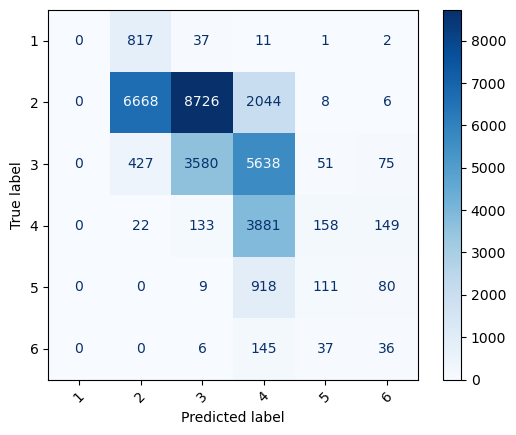

In [91]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn


cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
#print("Precision: ", precision_score(true_labels, predicted_labels))
#print("Recall: ", recall_score(true_labels, predicted_labels))
#print("F1: ", f1_score(true_labels, predicted_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

# OLD STUFF - IGNORE

## Setup

In [ ]:
#%pip install seaborn

In [12]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [120]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

In [121]:
csdata = ChargeStateDataset(data_source=train_datapath,seq_length=50, batch_size=batch_size, val_ratio=0.2, test=False)

# Dataset batches + split

In [122]:
import re
# the dictionary
aa_syntax_dictionary = dict()
for index, i in enumerate(list('XACDEFGHIKLMNPQRSTVWY')): # added X for 0 value
    aa_syntax_dictionary[i] = index * 100
    if i != 'X': # ignore 0 value for X
        for count in range(0, 100):
            aa_syntax_dictionary[i + "[UNIMOD:" + str(count) + "]"] = index * 100 + count

def seq_translator(sequence, dictionary=aa_syntax_dictionary, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    if print_result:
        print(result)
    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (50 - len(result))

    return [dictionary[aa] for aa in result]


def one_hot_precursor(int_value, charges=[2,3,4]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [123]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=True))
print(one_hot_precursor(2))

['A', 'A', 'C[UNIMOD:4]', 'L', 'L', 'V', 'A', 'W']

[100, 100, 204, 1000, 1000, 1800, 100, 1900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[1, 0, 0]


In [124]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [125]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [2, 3, 4] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df["modified_sequence_vector"] = df["modified_sequence"].apply(seq_translator)
    df["precursor_charge_vector"] = df["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    if counter > 1:
        break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [126]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [127]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity,modified_sequence_vector,precursor_charge_vector
0,LPGSLETYVEQEQGENANDR,2,29525630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000,...","[1, 0, 0]"
1,HGSLQEYLQNDTGSK,2,13188580.0,"[700, 600, 1600, 1000, 1400, 400, 2000, 1000, ...","[1, 0, 0]"
2,VEEEEEINSELTAR,2,20663460.0,"[1800, 400, 400, 400, 400, 400, 800, 1200, 160...","[1, 0, 0]"
3,LPGSLETYVEQEQGENANDR,2,19884630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000,...","[1, 0, 0]"
4,NSSTAEINETTTSSTDFLAR,2,12804420.0,"[1200, 1600, 1600, 1700, 100, 400, 800, 1200, ...","[1, 0, 0]"


In [128]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
Name: precursor_charge, dtype: int64

# Multi-label-dictionary

In [125]:
def multi_label_one_hot_precursor(charge_list, charges_included=[2,3,4]):

    one_hot_encoded = [1 if label in charge_list else 0 for label in charges_included]

    return one_hot_encoded

In [18]:
# Grouping by "modified_sequence" and aggregating precursor_charge into a list
grouped_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge"].agg(list).reset_index()
grouped_df

,modified_sequence,precursor_charge
0,AAAASAAEAGIATTGTEGER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, ..."
1,AAAC[UNIMOD:4]FFEQPPR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,AAADFATHGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,AAADLMAYC[UNIMOD:4]EAHAK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
4,AAADSDPNLDPLMNPHIR,"[3, 3, 3, 3]"
...,...,...
70310,YYVYWYQQLPGTTPK,"[2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
70311,YYYENSDQPIDLTK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
70312,YYYGHYLDDYHTK,"[2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, ..."
70313,YYYSDNFFDGQR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."


In [13]:
multi_label_df = grouped_df.copy()
multi_label_df["precursor_charge"] = grouped_df["precursor_charge"].apply(multi_label_one_hot_precursor)
multi_label_df["modified_sequence_vector"] = grouped_df["modified_sequence"].apply(seq_translator)


In [14]:
multi_label_df

,modified_sequence,precursor_charge,modified_sequence_vector
0,AAAASAAEAGIATTGTEGER,"[1, 1, 0]","[100, 100, 100, 100, 1600, 100, 100, 400, 100,..."
1,AAAC[UNIMOD:4]FFEQPPR,"[1, 0, 0]","[100, 100, 100, 204, 500, 500, 400, 1400, 1300..."
2,AAADFATHGK,"[1, 0, 0]","[100, 100, 100, 300, 500, 100, 1700, 700, 600,..."
3,AAADLMAYC[UNIMOD:4]EAHAK,"[1, 0, 0]","[100, 100, 100, 300, 1000, 1100, 100, 2000, 20..."
4,AAADSDPNLDPLMNPHIR,"[0, 1, 0]","[100, 100, 100, 300, 1600, 300, 1300, 1200, 10..."
...,...,...,...
70910,YYVYWYQQLPGTTPK,"[1, 1, 0]","[2000, 2000, 1800, 2000, 1900, 2000, 1400, 140..."
70911,YYYENSDQPIDLTK,"[1, 0, 0]","[2000, 2000, 2000, 400, 1200, 1600, 300, 1400,..."
70912,YYYGHYLDDYHTK,"[1, 1, 1]","[2000, 2000, 2000, 600, 700, 2000, 1000, 300, ..."
70913,YYYSDNFFDGQR,"[1, 0, 0]","[2000, 2000, 2000, 1600, 300, 1200, 500, 500, ..."


### import preprocessed df's

In [351]:
# Make validation data
sample_df = batches_parquet[file_list[0]][["precursor_charge", "precursor_intensity", "modified_sequence_vector"]].copy()

In [352]:
sample_df

,precursor_charge,precursor_intensity,modified_sequence_vector
0,2,29525630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000, 1800, 400, 1400, 400, 1400, 600, 400, 1200, 100, 1200, 300, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2,13188580.0,"[700, 600, 1600, 1000, 1400, 400, 2000, 1000, 1400, 1200, 300, 1700, 600, 1600, 900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,20663460.0,"[1800, 400, 400, 400, 400, 400, 800, 1200, 1600, 400, 1000, 1700, 100, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,2,19884630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000, 1800, 400, 1400, 400, 1400, 600, 400, 1200, 100, 1200, 300, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,12804420.0,"[1200, 1600, 1600, 1700, 100, 400, 800, 1200, 400, 1700, 1700, 1700, 1600, 1600, 1700, 300, 500, 1000, 100, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...
6080601,3,573697.7,"[2000, 1600, 1400, 1000, 500, 204, 600, 1000, 1300, 1600, 1000, 700, 1600, 400, 1600, 1000, 1800, 100, 1700, 500, 1100, 600, 1600, 1400, 600, 1000, 1300, 900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
6080602,3,573697.7,"[2000, 1600, 1400, 1000, 500, 204, 600, 1000, 1300, 1600, 1000, 700, 1600, 400, 1600, 1000, 1800, 100, 1700, 500, 1100, 600, 1600, 1400, 600, 1000, 1300, 900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
6080603,3,114742.8,"[400, 1100, 400, 1200, 500, 1800, 1400, 1600, 1600, 600, 400, 300, 600, 800, 1800, 1800, 500, 1600, 1000, 600, 1600, 1000, 500, 1400, 1200, 1800, 1700, 400, 400, 900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6080604,3,114742.8,"[400, 1100, 400, 1200, 500, 1800, 1400, 1600, 1600, 600, 400, 300, 600, 800, 1800, 1800, 500, 1600, 1000, 600, 1600, 1000, 500, 1400, 1200, 1800, 1700, 400, 400, 900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [560]:
# Split the data into train, validation, and test sets
sample_df["precursor_intensity"] = sample_df["precursor_intensity"].astype(int) # TODO or times 10 -> 0.1 = 1 .astype(int)
main_ds = np.array(sample_df[["precursor_intensity", "modified_sequence_vector"]]) # to list
main_ds_labels = np.array(sample_df['precursor_charge'])
max_len = max(sample_df.loc[:, 'modified_sequence_vector'].apply(len))  # Find the maximum length


# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies, val_indicies = next(sss.split(main_ds, main_ds_labels))
train_ds, train_ds_labels = main_ds[train_indicies], main_ds_labels[train_indicies]
val_ds, val_ds_labels = main_ds[val_indicies], main_ds_labels[val_indicies]


charges = [2,3,4] # TODO SELECT CLASSES
num_classes = len(charges)

train_ds_labels, val_ds_labels = np.array([one_hot_precursor(i, charges = charges) for i in train_ds_labels]), np.array([one_hot_precursor(i, charges = charges) for i in val_ds_labels])

### Model

In [561]:
train_ds_b[1][0]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([600])>

In [562]:
train_ds.shape

(4776215, 2)

In [710]:
train_ds_a, train_ds_b, val_ds_a, val_ds_b = train_ds[:, 0], train_ds[:, 1:], val_ds[:, 0], val_ds[:, 1:]

In [711]:
train_ds_a = train_ds_a.reshape(train_ds_a.shape[0], 1)
val_ds_a = val_ds_a.reshape(val_ds_a.shape[0], 1)

In [565]:
train_ds_a.shape

(4776215, 1)

In [712]:
train_ds_a = tf.convert_to_tensor(train_ds_a, dtype=tf.int32)
val_ds_a = tf.convert_to_tensor(val_ds_a, dtype=tf.int32)

In [545]:
# train_ds_b = [np.array(x[0]).reshape(-1,1) for x in train_ds_b] # todo for rows

In [713]:
train_ds_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in train_ds_b]
val_ds_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in val_ds_b]

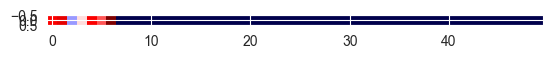

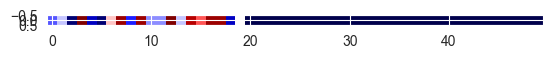

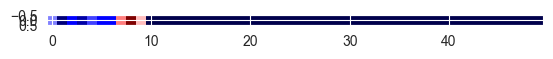

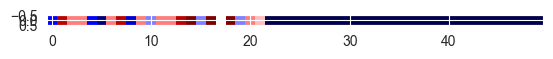

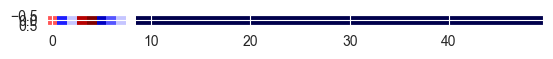

In [714]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds_b[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [715]:
train_ds_b = tf.convert_to_tensor(train_ds_b)
val_ds_b = tf.convert_to_tensor(val_ds_b)

In [620]:
train_ds_b.shape

TensorShape([4776215, 1, 50, 1])

In [621]:
train_ds_b.shape[1:]

TensorShape([1, 50, 1])

In [619]:
train_ds_a.shape

(4776215,)

In [703]:
val_ds.shape

(1194054, 2)

In [690]:
#train_ds_labels = tf.convert_to_tensor(train_ds_labels)
#val_ds_labels = tf.convert_to_tensor(val_ds_labels)

In [701]:
train_ds_labels.shape

TensorShape([4776215, 3])

In [702]:
val_ds_labels.shape

TensorShape([1194054, 3])

In [742]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=(1,)) # TODO only 1 column for intensities
inputB = Input(shape=train_ds_b.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
#y = Rescaling(scale=1./2000)(inputB) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=32, kernel_size=(1,3), strides=1, activation="relu", padding='same')(inputB)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=64, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
#y = Dense(50, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression p0rediction on the
# combined outputs
z = Dense((inputA.shape[1]+inputB.shape[1]), activation="relu")(combined) # 1 + 50 = 51
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(combined)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [743]:
model.summary()

Model: "model_317"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_350 (InputLayer)         [(None, 1, 50, 1)]   0           []                               

                                                                                                  

 conv2d_46 (Conv2D)             (None, 1, 50, 32)    128         ['input_350[0][0]']              

                                                                                                  

 input_349 (InputLayer)         [(None, 1)]          0           []                               

                                                                                                  

 flatten_29 (Flatten)           (None, 1600)         0           ['conv2d_46[0][0]']              

                                                                               

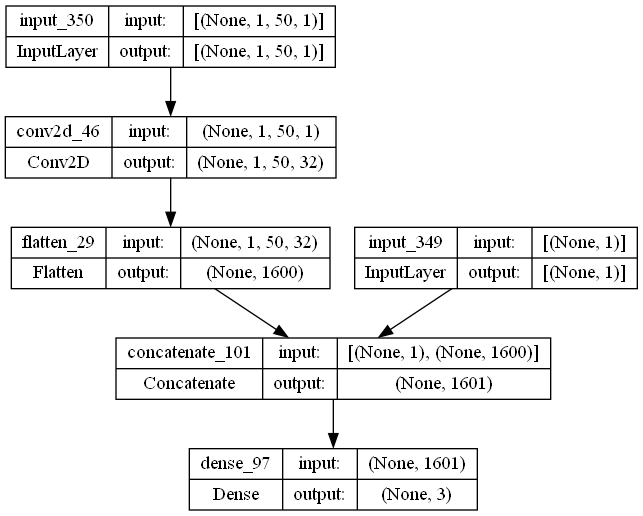

In [744]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [745]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [746]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [683]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [747]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit([train_ds_a, train_ds_b], train_ds_labels, epochs=30, batch_size=4096, validation_data=([val_ds_a, val_ds_b], val_ds_labels), callbacks=[WandbCallback()])

Epoch 1/30

1167/1167 [==============================] - 50s 43ms/step - loss: 39031.9141 - accuracy: 0.6001 - val_loss: 866.1899 - val_accuracy: 0.7068

Epoch 2/30

1167/1167 [==============================] - 49s 42ms/step - loss: 1036.0096 - accuracy: 0.6224 - val_loss: 396.5641 - val_accuracy: 0.6974

Epoch 3/30

1167/1167 [==============================] - 48s 41ms/step - loss: 884.3662 - accuracy: 0.6260 - val_loss: 533.0513 - val_accuracy: 0.6991

Epoch 4/30

1167/1167 [==============================] - 48s 41ms/step - loss: 934.1490 - accuracy: 0.6277 - val_loss: 1992.9141 - val_accuracy: 0.4079

Epoch 5/30

1167/1167 [==============================] - 49s 42ms/step - loss: 982.3355 - accuracy: 0.6278 - val_loss: 566.3272 - val_accuracy: 0.6936

Epoch 6/30

1167/1167 [==============================] - 51s 43ms/step - loss: 847.4366 - accuracy: 0.6304 - val_loss: 747.9620 - val_accuracy: 0.6303

Epoch 7/30

1167/1167 [==============================] - 49s 42ms/step - loss: 837.5

In [748]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [758]:
model.save('precursor_charge_prediction_conv2d_model/model_1_test.h5')

# Inference

In [751]:
# Make validation data
sample_df_inf = batches_parquet[file_list[1]][["precursor_charge", "precursor_intensity", "modified_sequence_vector"]].copy()

In [752]:
# Split the data into train, validation, and test sets
sample_df_inf["precursor_intensity"] = sample_df_inf["precursor_intensity"].astype(int) # TODO or times 10 -> 0.1 = 1 .astype(int)
main_ds_inf = np.array(sample_df_inf[["precursor_intensity", "modified_sequence_vector"]]) # to list
main_ds_labels_inf = np.array(sample_df_inf['precursor_charge'])
max_len_inf = max(sample_df_inf.loc[:, 'modified_sequence_vector'].apply(len))  # Find the maximum length

charges = [2,3,4] # TODO SELECT CLASSES
num_classes = len(charges)

main_ds_labels_inf = np.array([one_hot_precursor(i, charges = charges) for i in main_ds_labels_inf])

In [753]:
main_ds_inf_a, main_ds_inf_b = main_ds_inf[:, 0], main_ds_inf[:, 1:]

In [754]:
main_ds_inf_a = main_ds_inf_a.reshape(main_ds_inf_a.shape[0], 1)
main_ds_inf_a = tf.convert_to_tensor(main_ds_inf_a, dtype=tf.int32)
main_ds_inf_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in main_ds_inf_b]

In [ ]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds_b[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [755]:
for batch in main_ds_inf.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_ordinal(y, num_classes=3, dtype='int') # num_classes = 1 for binary, else = num_classes; to_categorical for multiclass
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [756]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')

In [757]:
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from matplotlib import cm
import tensorflow as tf
import numpy as np


for layerpos in range(len(model.layers)-1):
    try:
        image_size = general_image_size

        # Load pre-trained Keras model and the image to classify TODO VERIFY
        img_tensor = labeled
        img_tensor = np.expand_dims(img_tensor, axis=0)

        select_layer = model.layers[layerpos].name #was -4
        print(select_layer)
        conv_layer = model.get_layer(select_layer)
        heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

        heatmaps_generated = set()
        heatmap_list = []
        for pndex, value in enumerate(predictions[0]):
            with tf.GradientTape() as gtape:
                conv_output, predictions = heatmap_model(img_tensor)
                loss = predictions[0][pndex]
                grads = gtape.gradient(loss, conv_output)
                pooled_grads = K.mean(grads, axis=(0, 1, 2))

            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            max_heat = np.max(heatmap)
            if max_heat == 0:
                max_heat = 1e-10
            heatmap /= max_heat
            heatmaps_generated.add(heatmap.shape)
            heatmap_list.append(heatmap)
        print(heatmaps_generated)

        images_hm = []
        titles_hm = []
        predictions_hm = []

        for i in range(num_classes):
            # predictions
            prediction_value = (predictions[0][i])
            predictions_hm.append(prediction_value)

            # titles
            title = class_names[i]
            titles_hm.append(title)

            # images
            hm=np.squeeze(heatmap_list[i])

            current_img = (asarray(hm))
            sm = cm.ScalarMappable(cmap='seismic')
            sm.set_clim(current_img.min(), current_img.max())
            current_img = sm.to_rgba(current_img)
            current_img = current_img*255
            current_img = current_img.astype(np.uint8)
            current_img = cv2.cvtColor(current_img, cv2.COLOR_BGRA2BGR )
            images_hm.append(current_img)

        # plot them
        #print(len(images_hm))
        plot_image_grid(images_hm, titles_hm, predictions_hm, layername=select_layer)
    except:
        print("error", layerpos, end=" ")


## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [285]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
Name: precursor_charge, dtype: int64

In [286]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

In [287]:
batches_parquet.keys()

dict_keys(['data/Thermo_SRM_Pool_meta_data.parquet', 'data/TUM_aspn_meta_data.parquet'])

In [288]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [289]:
inference_df.head(4)

,precursor_charge,modified_sequence_vector,precursor_intensity
0,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7552496.0
1,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7674974.0
2,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
3,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",1224600.0


In [290]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

[]

In [291]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [292]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

[]

In [293]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

[]

In [294]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

[]

In [295]:
inference_df

,precursor_charge,modified_sequence_vector,precursor_intensity
0,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7552496.0
1,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7674974.0
2,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
3,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",1224600.0
4,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
...,...,...,...
2586142,3,"[300, 1800, 1000, 1600, 1200, 204, 400, 500, 1...",10454540.0
2586148,3,"[300, 800, 1500, 800, 900, 400, 400, 400, 1300...",5171662.0
2586154,4,"[300, 400, 1400, 1800, 100, 1000, 900, 900, 90...",37526080.0
2586155,3,"[300, 1300, 300, 1300, 1400, 1300, 1500, 2000,...",8926203.0


In [296]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

KeyboardInterrupt: 

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [ ]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [ ]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

MCC

In [ ]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

Direct eval:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [ ]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')